# Covid Survival in Mexico Analysis

## 1. Business Understanding

**1.1 - Background** : After three years of pandemic, all the world knows about COVID19, a virus that causes severe acute respiratory syndrome (SARS-CoV-2). Over 106 million SARS-CoV-2 infections and over 2.3 million fatalities have been reported as of the first week of February 2021. This epidemic has severely disrupted global economic activity. 
In response to the worldwide public health crisis, scientists and physicians have worked very hard to give new insights and develop technology solutions that may assist in combating this infectious sickness and lessening its effects. <br>
<br>
Artificial intelligence approaches have been recognized in this context as a potent and promising technology that may help with:
<ul>
    <li>the diagnostic process</li>
    <li>prediction of disease spreading dynamics</li>
    <li>tracking of infected patients</li>
    <li> tracking of potential future patients</li>
    <li> determine if a particular patient poses a mortality risk</li>
</ul>

**1.2 - Business Objectives**: In this scenario is important to improve hospital capacity planning and ensure that patient receive timely treatment.

**1.3 - Business Success Criteria**: The business success criterias are met if health care priorities are currenty assigned and identify high-risk patients are quickly identified.

**1.4 - Situation**: To our disposal we have a dataset containing 4 million entries of 40 attributes, each one containing information about a patient 

#todooooooooo

**1.5 - Data Mining Goals**: Correctly identify patients who are more likely to die and patients who are more likely to survive.

**1.6 - Data Mining Success Criteria**: The success criteria are satisfied if the model is able to identify patient with high precision in a fast way.

## 2. Data Understanding

**2.1 - Initial Data Collection**

In [1]:
# libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

sns.set_style("darkgrid")
sns.set_palette("Set2")

In [2]:
df = pd.read_csv("./dataset/COVID19MEXICO2020.csv")

/var/folders/rr/stc45rdd10q7w37xr3dvpzt40000gn/T/ipykernel_3419/3753177704.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./dataset/COVID19MEXICO2020.csv")


In [3]:
print(f"Data has {df.shape[0]} rows and {df.shape[1]} attributes")

Data has 3868396 rows and 40 attributes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3868396 entries, 0 to 3868395
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

**2.2 - Data Description:** The dataset is composed of 39 features and 1 target variable (TIPO_PACIENTE).

The target variable is a categorical dependent variable that can be _1_ if the patient is more likely to survive or _2_ if the patient is more likely to die. 

We can see that the dataset is unbalanced (there are more paients who are more likely to survive than to die). This may cause our model to be biased and always predict the majority class with still retaining an higher level of accuracy. There are multiple solutions to this problem: one can be oversampling the minority class to balance the result but it may introduce dublicates and bias. Another solution can be to assign weigth to the classes and force the model to pay attention also to the minority. 

In [5]:
df[["TIPO_PACIENTE"]].value_counts()

TIPO_PACIENTE
1                3340218
2                 528178
dtype: int64

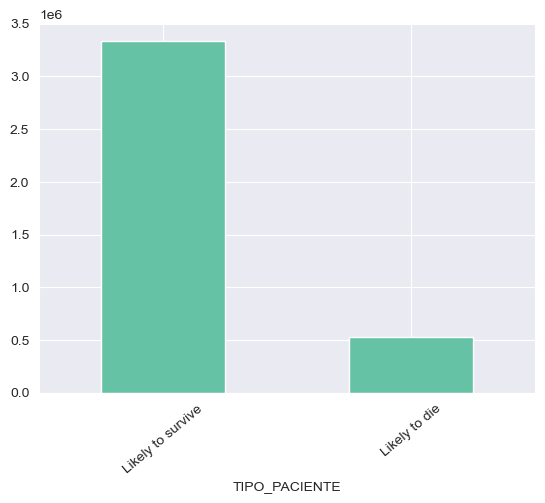

In [6]:
ax = df[["TIPO_PACIENTE"]].value_counts().plot(kind="bar")
ax.set_xticklabels(['Likely to survive', 'Likely to die'], rotation=40)
plt.show()

Features can be divided into 3 categories:

In [7]:
# categorical values have numerical identifier 
name_dict = {'SI': 1, 'NO': 2, 'DO NOT KNOW': 97, 'ANSWER REFUSED': 98, 'NOT APPLICABLE': 99}

1. Medical History:

In [8]:
medical_history = ['DIABETES',  #Diabetes = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OBESIDAD', #Obesity = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'ASMA', #Asthma = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'HIPERTENSION', #Hypertension = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'RENAL_CRONICA', #Chronic renal failure = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'CARDIOVASCULAR', #Cardiovascular diseases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EMBARAZO', #Pregnancy = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'TABAQUISMO', #Smoking = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EPOC', #COPD = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'INMUSUPR', #Immunosuppressive drugs = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OTRA_COM' #Other chronic illnesses = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
]

In [9]:
len(medical_history)

11

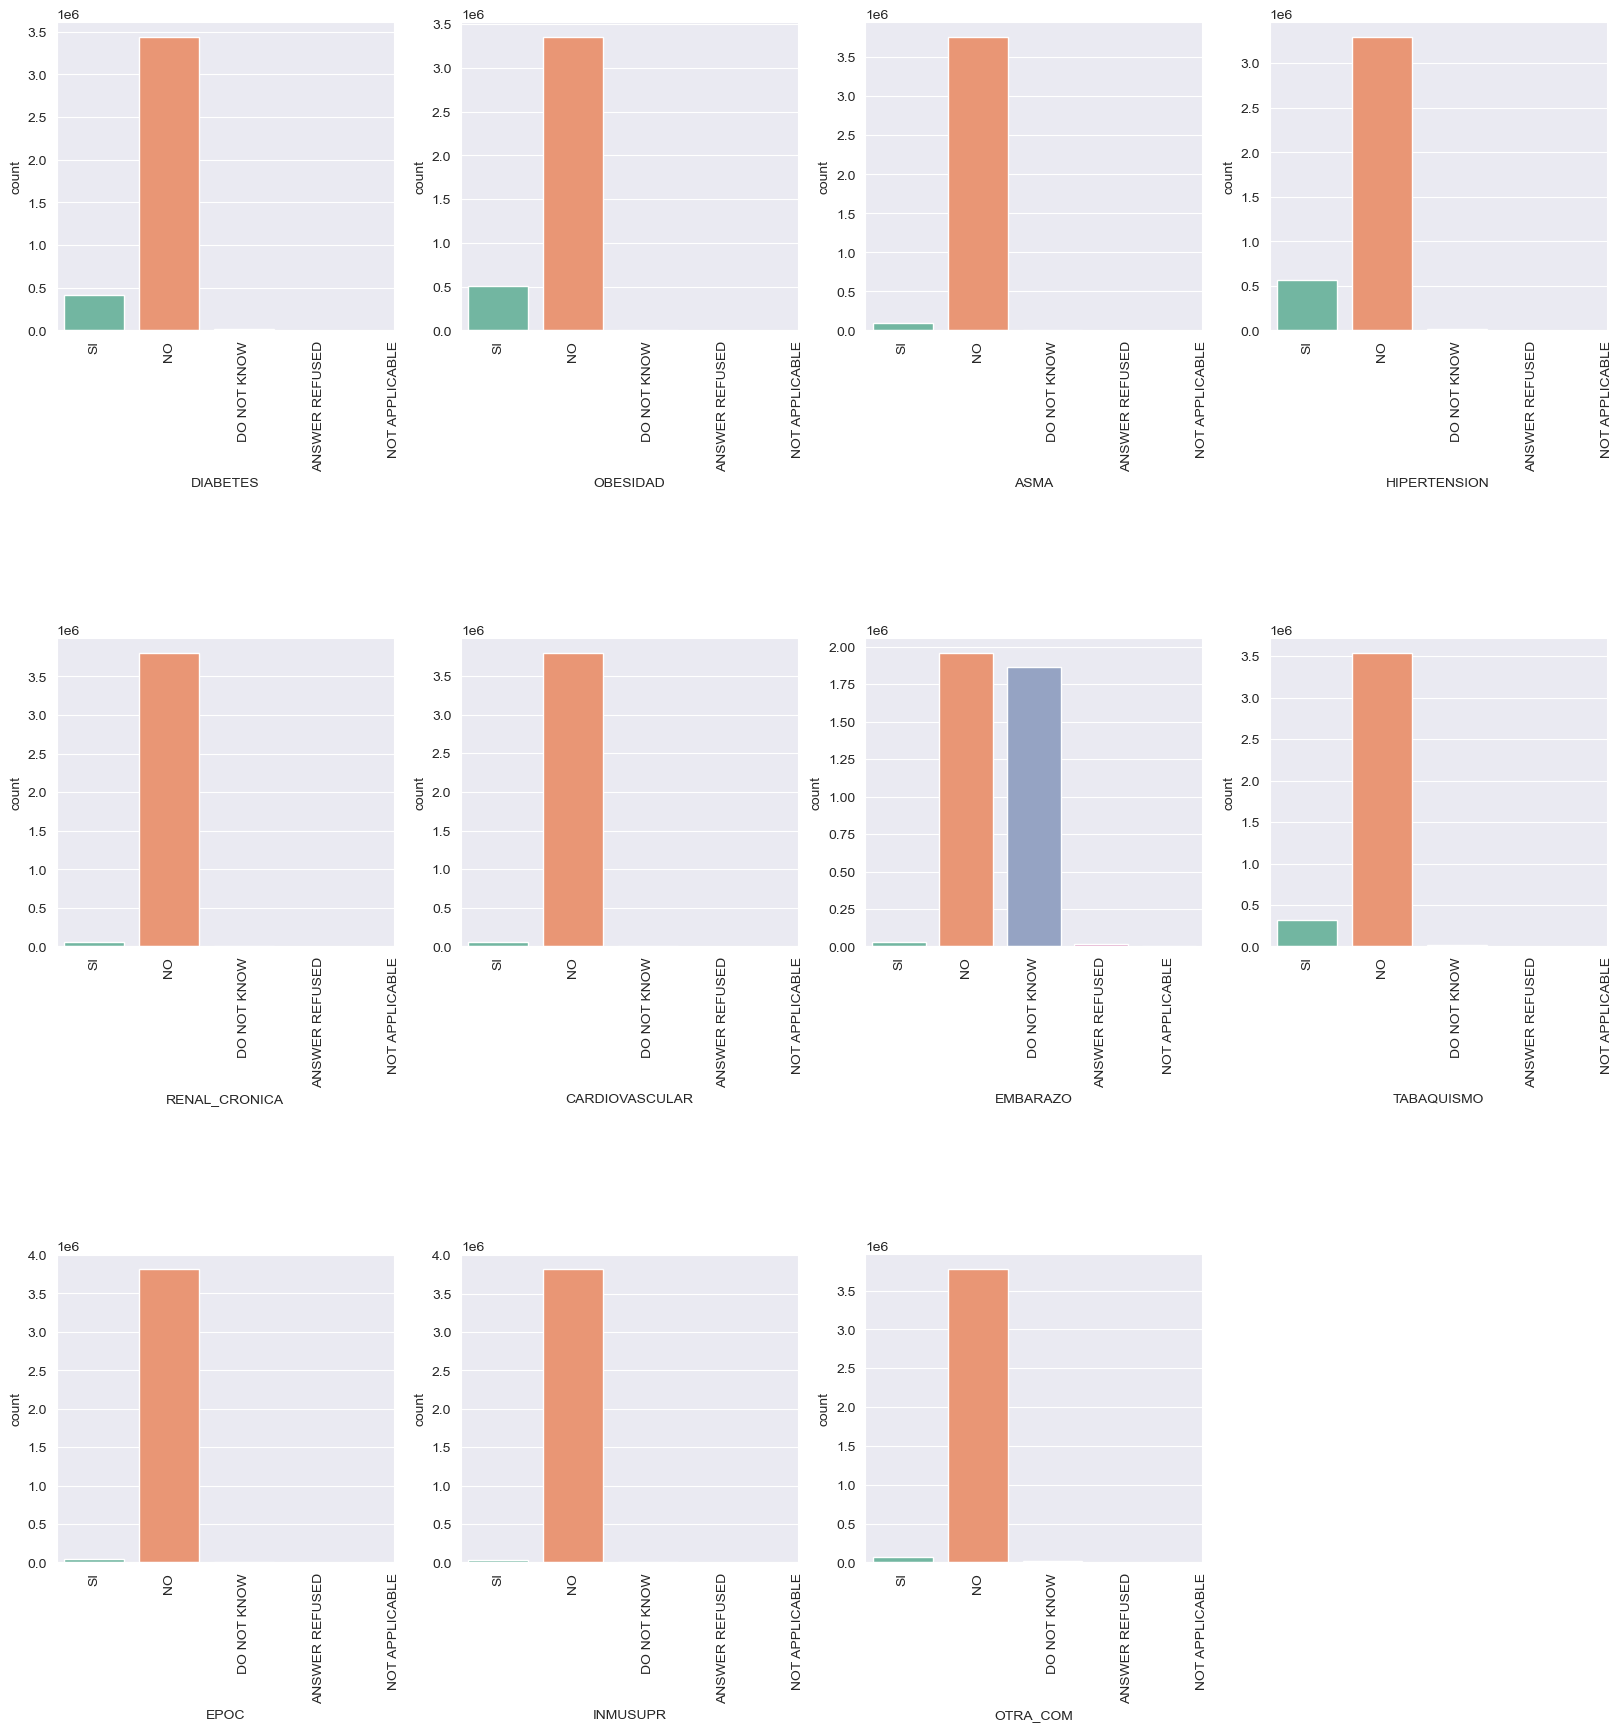

In [10]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_history, ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
fig.delaxes(ax[2,3])

We can detect an high number of NaNs in 'EMBARAZO' (probably, this feature won't be of much help in our research due to this).<br>
We can observe that the majority of the patients weren't in poor health (2=NO). <br>
All this variables are categorical (1=Yes, 2=No, 97=Don't Know, 98=Answer Refused, 99=Not Applicable).

2. Demographic Data:

In [11]:
demographic_data = ['SEXO', #gender (M/F)=(1/2)
                    'NACIONALIDAD', #nationality (1=mexican , 2=foreigner)
                    'INDIGENA', #indigeneous = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'HABLA_LENGUA_INDIG', #Indigeneous language = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'MIGRANTE', #migrant = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'PAIS_ORIGEN', #state of birth = categorical (text)
                    'PAIS_NACIONALIDAD', #state of residence  = categorical (text)
                    'ENTIDAD_NAC', #entity where patient was born = categorical (text)
                    'ENTIDAD_RES', #entity where patient is resident = categorical (text)
                    'EDAD', #age = numerical
                    'MUNICIPIO_RES', #municial where patient is resident = categorical (text)

                   ]

In [12]:
len(demographic_data)

11

[Text(0, 0, 'MEXICAN'), Text(1, 0, 'FOREIGNER')]

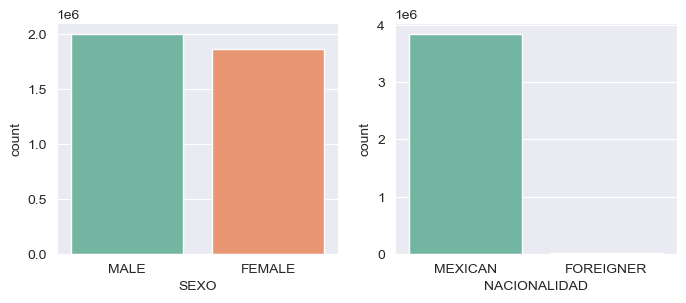

In [13]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.countplot(x=df[demographic_data[0]], ax=ax1).set_xticklabels(['MALE', 'FEMALE'])
sns.countplot(x=df[demographic_data[1]], ax=ax2).set_xticklabels(['MEXICAN', 'FOREIGNER'])

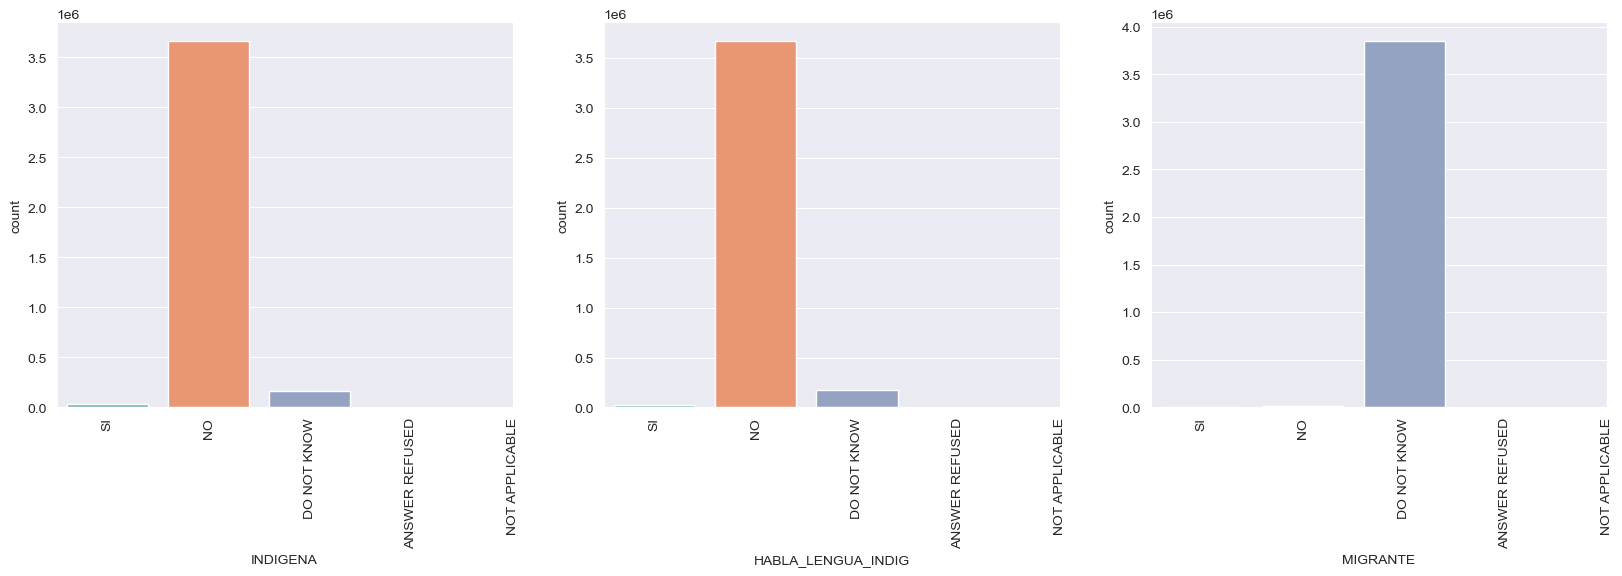

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for variable, subplot in zip(demographic_data[2:5], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

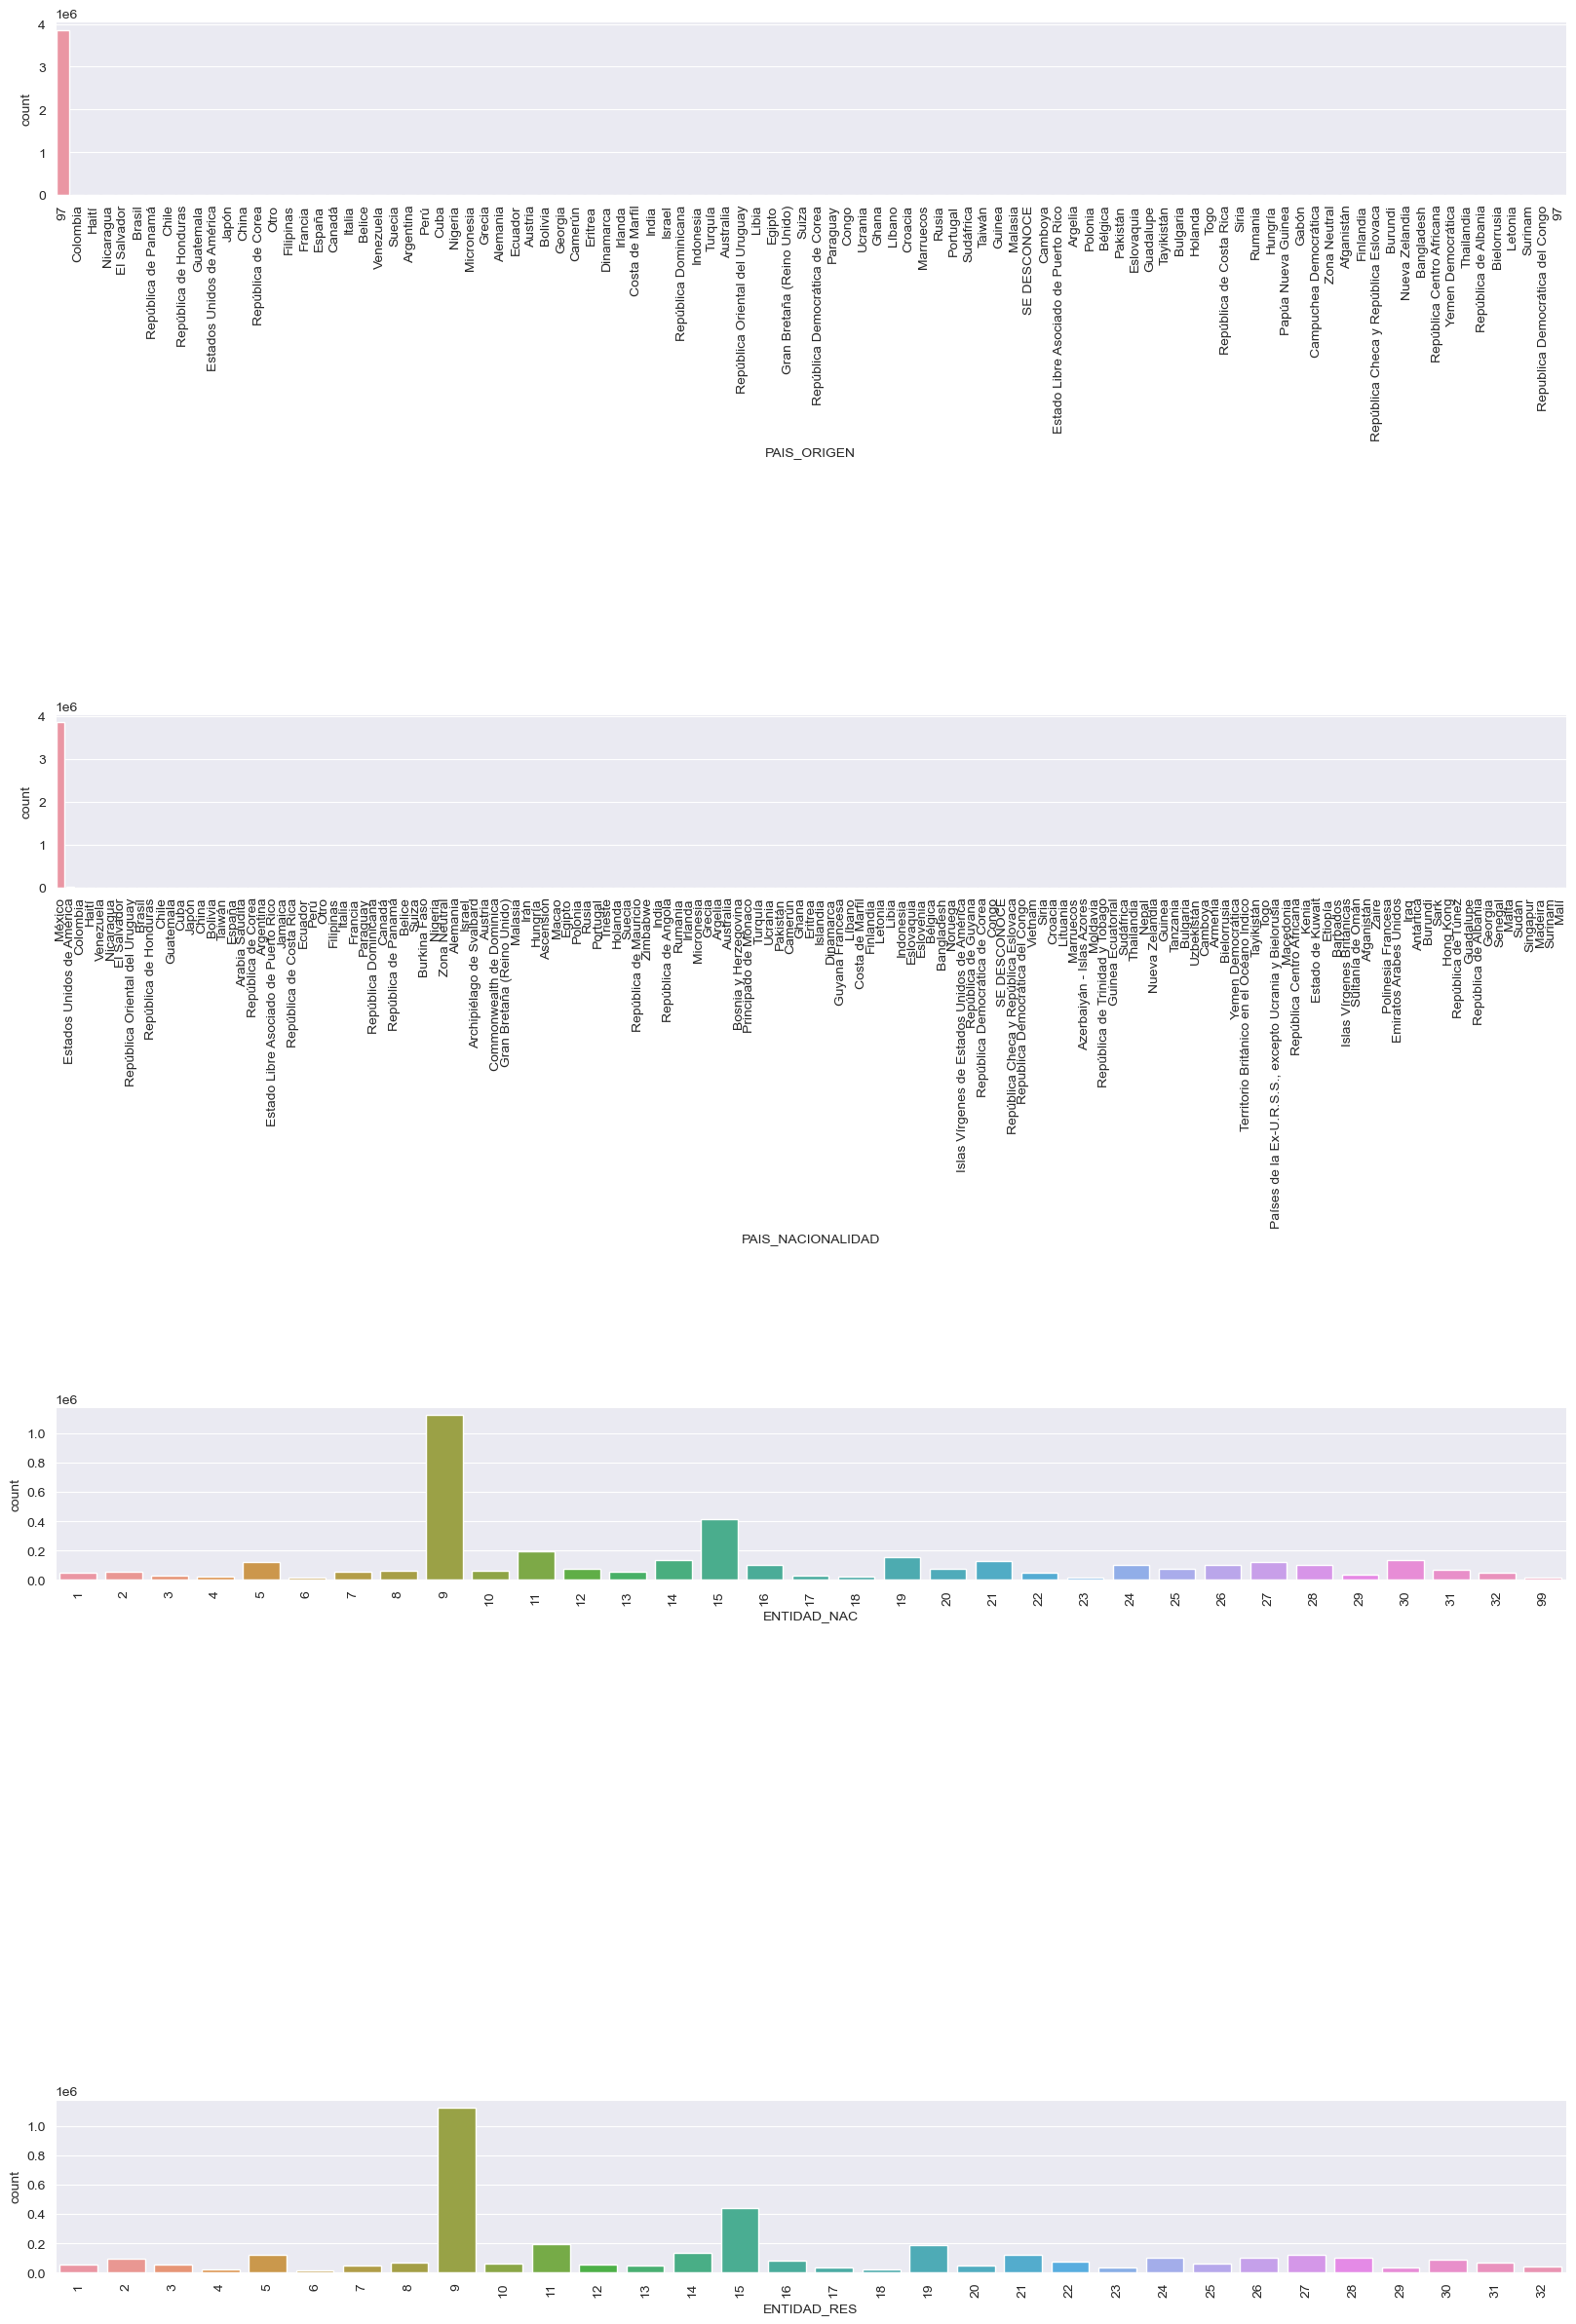

In [15]:
fig, ax = plt.subplots(4, 1, figsize=(20, 30))
fig.subplots_adjust(hspace=3)
for variable, subplot in zip(demographic_data[5:9], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

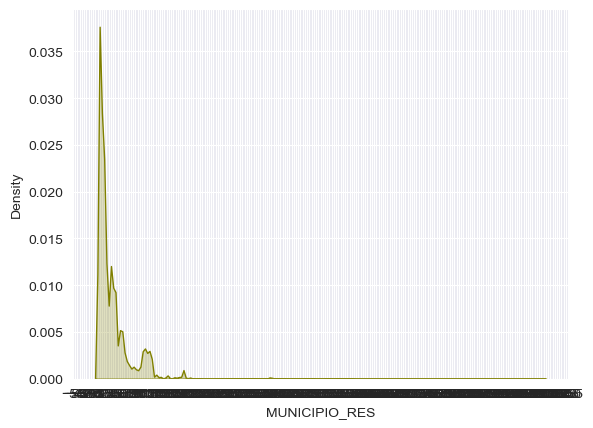

In [16]:
ax = sns.kdeplot(x=df[demographic_data[10]], shade=True, color="olive")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

In [17]:
df[['MUNICIPIO_RES']].value_counts()

MUNICIPIO_RES
7                224596
5                204191
4                145925
2                143183
10               134289
                  ...  
535                   1
236                   1
538                   1
341                   1
518                   1
Length: 522, dtype: int64

Again:
- in 'MIGRANTE' (migran) we can see many NaN's (97,98,99)
- from the other features we can derive that most of the people is mexican
- we can notice some outliers in the feature 'EDAD' (age): it's not likely that someone had 120 years
- male and female are balanced

3. Recent Medical Info

In [18]:
medical_info = ['ID_REGISTRO', #id register = categorical (text)
                
                'ORIGEN', #system of respiratory disease monitoring health units (USMER) = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'INTUBADO', #if the patient required intubation = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'NEUMONIA', #PNEUMONIA = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'OTRO_CASO', #if it has had contact with other covid cases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_LAB', #sample lab taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_LAB', #test covid19 result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_ANTIGENO', #test antigeno taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_ANTIGENO', #test covid19 antigeno result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'UCI'#if the patients was in the intense unit = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                
                'CLASIFICACION_FINAL', #Identifies if the patient is a case of COVID-19 = categorical (1-7)
                'ENTIDAD_UM', #entity where the medical unit that provided = categorical
                'TIPO_PACIENTE', #type of attention that the patient has received on arrival = categorical (Ambulatorio/hospitalizado)
                
                'FECHA_SINTOMAS', #date of start symbols (YYYY-MM-DD)
                'FECHA_INGRESO', #date of arrival into medical unit (YYYY-MM-DD)
                'FECHA_DEF', #date of death (YYYY-MM-DD)
]

In [19]:
len(medical_info)

15

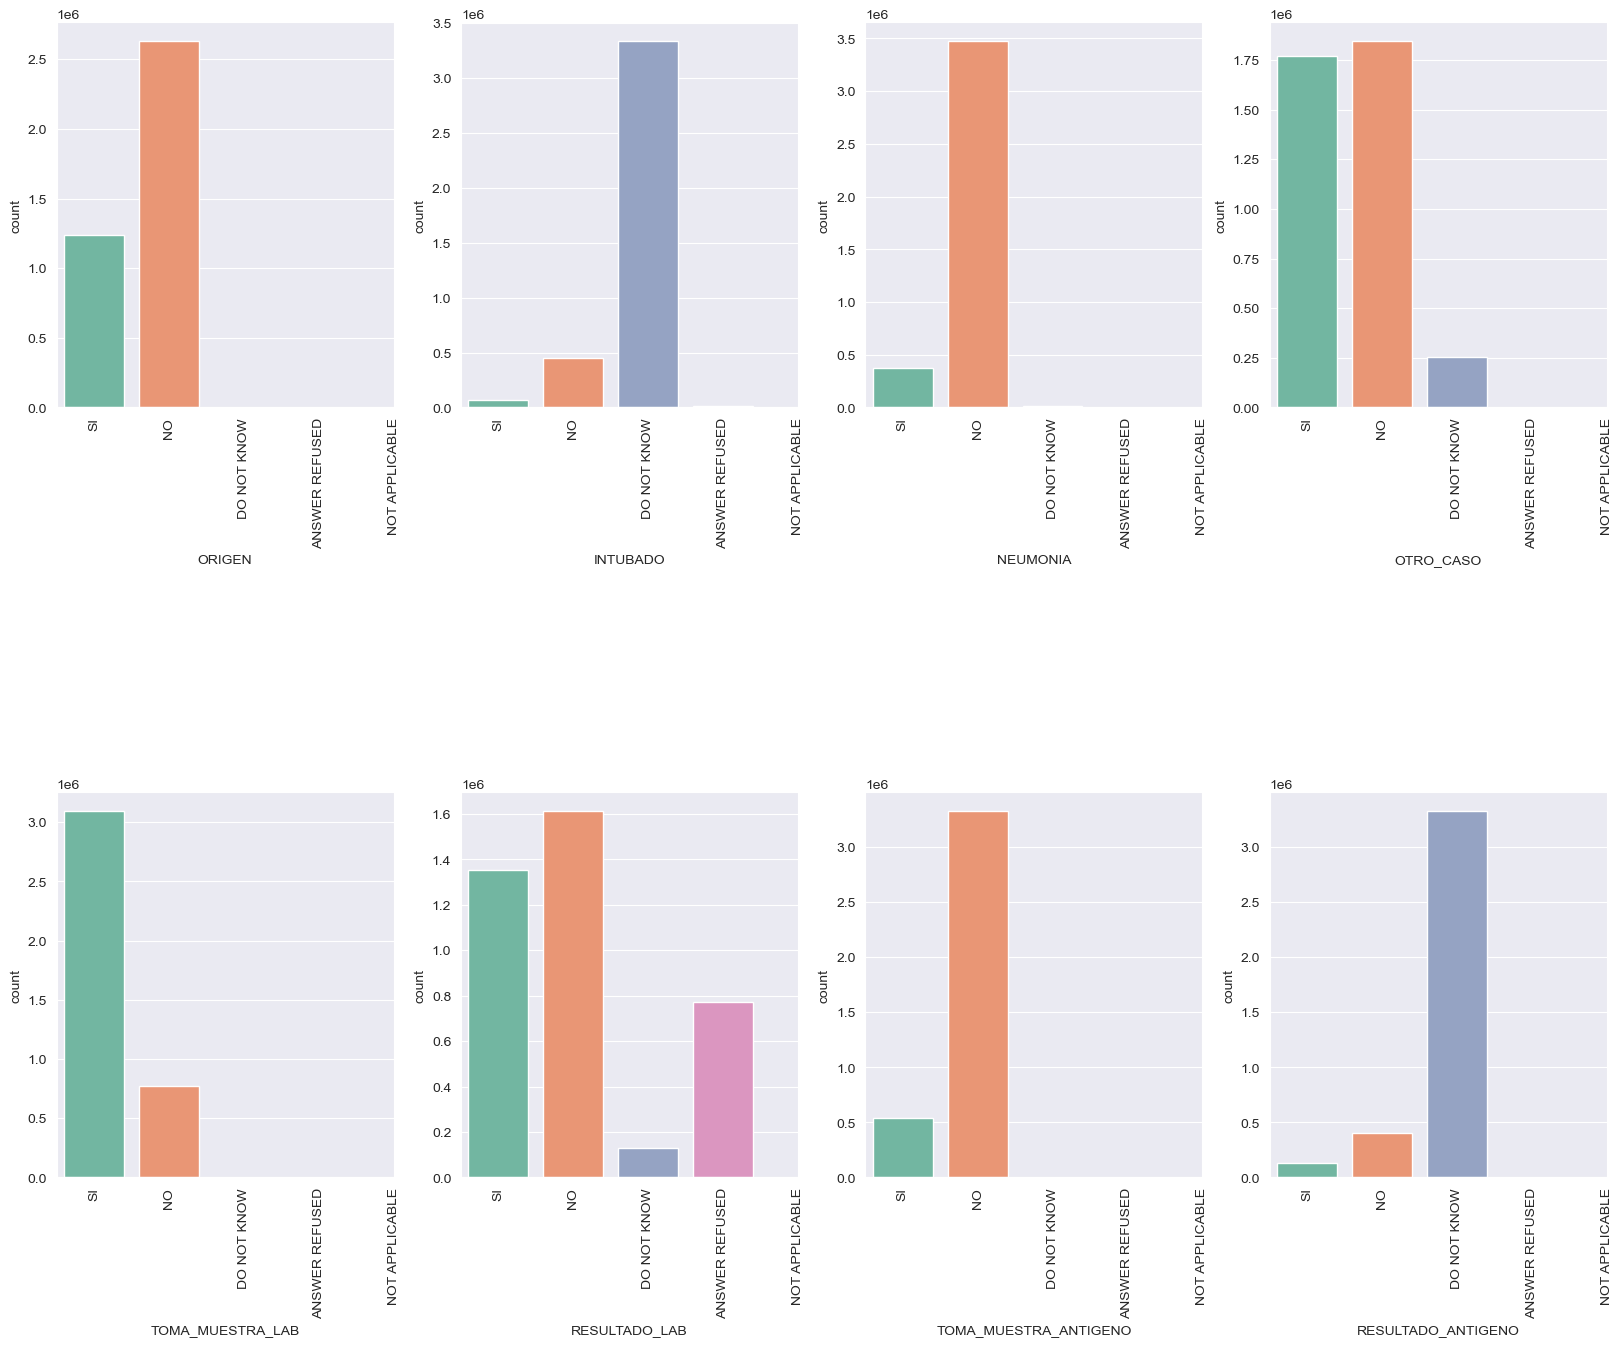

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_info[1:9], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'Covid19'), Text(1, 0, 'Healthy')]

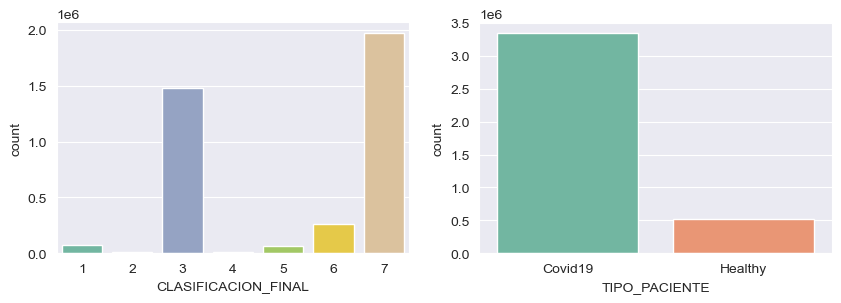

In [21]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(x=df['CLASIFICACION_FINAL'], ax=ax1)

c2 = sns.countplot(x=df['TIPO_PACIENTE'], ax=ax2)
c2.set_xticklabels(['Covid19', 'Healthy'])

In [22]:
# death is set to 9999-99-99 if patient is not dead
df[medical_info[-1]].value_counts()

#convert into nan to plot it
df.replace('9999-99-99', np.nan, inplace=True)

In [23]:
# convert to date
for f in medical_info[12:15]:
    df[f] =  pd.to_datetime(df[f])

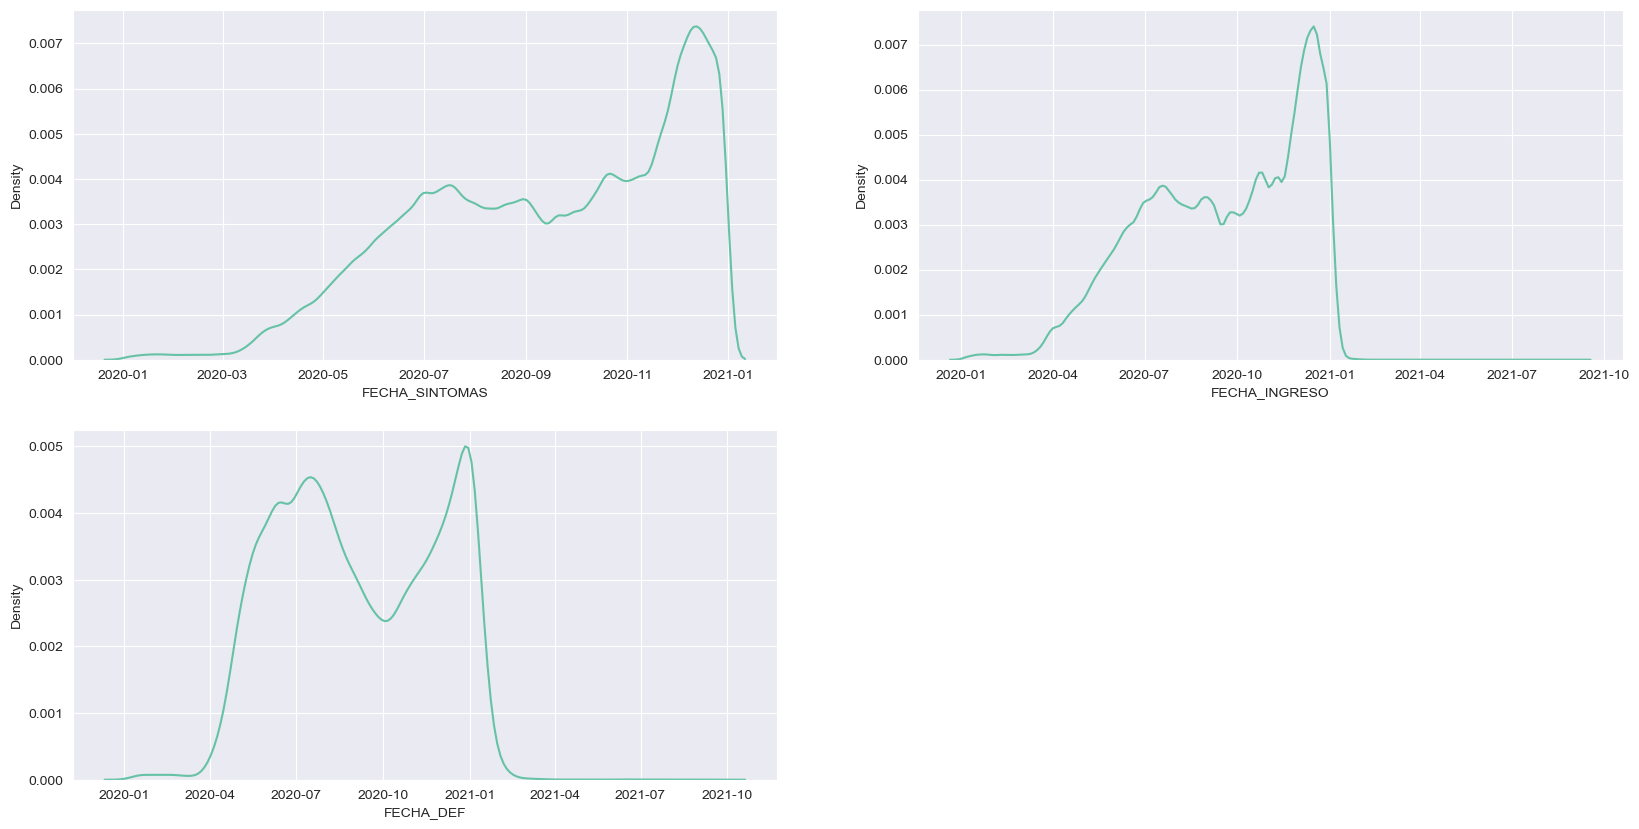

In [24]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
for variable, subplot in zip(medical_info[12:15], ax.flatten()):
    chart = sns.kdeplot(x=df[variable], ax=subplot)
fig.delaxes(ax[1,1])

From the 'FECHA_SINTOMAS' we can clearly see a peak around the lasts month of the 2020, meaning covid19 here are a massive spread. On the same dates, we can see that many people went to the hospital ('FECHA_INGRESO'). The 'Start of symptoms' and 'Arrival to the hospital' curve are similar: there is a correlation between the two. 

The peak for the deaths, on the other hand, are arount the lasts month of 2020 as well but also on the summer of 2020.

**2.3 - Data Exploration:**

In [25]:
# we are going to consider 97,98,99 as NaN's values since they correspond to Don't know, Answer Refused, Not Applicable
# and this values are of no use to us
df.replace([97, 98, 99], np.nan, inplace=True)

In [26]:
col_numeric = df.select_dtypes([np.number]).columns
col_obj = df.select_dtypes([object, 'datetime64[ns]']).columns

In [27]:
df[['UCI']].isna().sum()

UCI    3351527
dtype: int64

<AxesSubplot:>

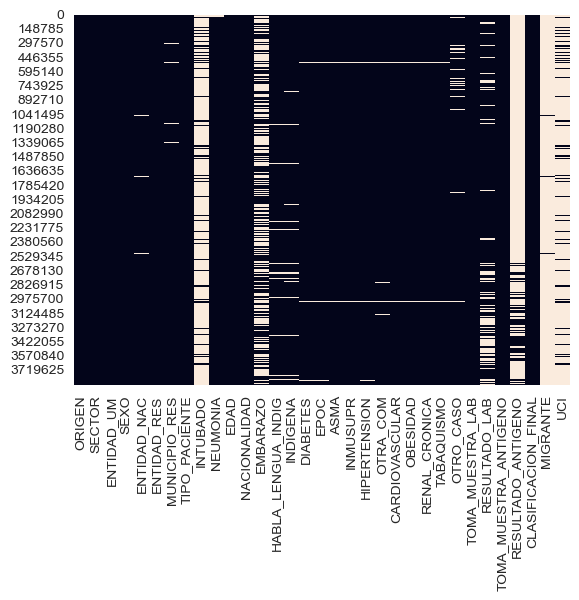

In [28]:
# percentage of nan values in numeric columns:
sns.heatmap(df[col_numeric].isna(), cbar=False)

From this heatmap we can individualize with more clarity the columns with high percentage of nan values: like 'MIGRANTE' for example and 'UCI', 'RESULTADO ANTIGENO', 'INTUBADO',  'EMBARAZO'. Columns that have an high percentage of nan values are no useful to our problem. They will be removed in the future. 

<AxesSubplot:>

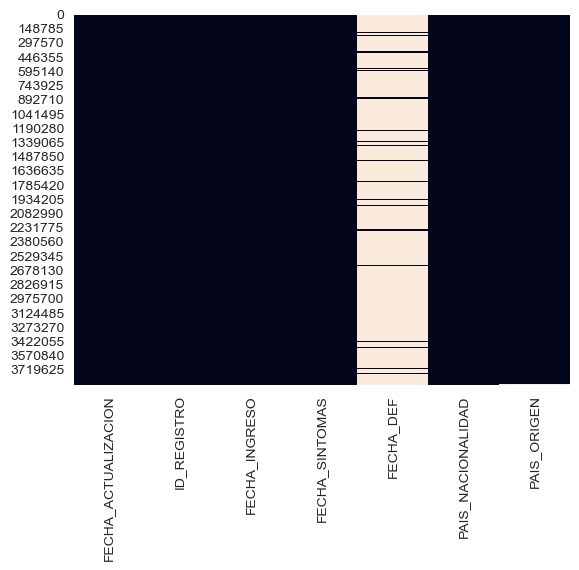

In [29]:
# percentage of nan values in non numeric columns:
sns.heatmap(df[col_obj].isna(), cbar=False)

Due to the nature of our problem (decide is a patient is likely to die or to survive) we won't have the column 'date of death' populated in real life cases. So we can remove it. 

In [30]:
# how many days between the start of sintoms and the ingress at the hospital?
df['DAYS_IN_BETWEEN'] = (df['FECHA_INGRESO'] - df['FECHA_SINTOMAS']).astype('timedelta64[D]').astype('int64')

In [31]:
df['DAYS_IN_BETWEEN'].value_counts().sort_index()

-13          1
 0      726249
 1      447575
 2      515154
 3      526542
         ...  
 247         1
 258         1
 265         1
 328         1
 430         1
Name: DAYS_IN_BETWEEN, Length: 110, dtype: int64

Text(0.5, 1.0, 'Days between start of syntoms and hospitalization')

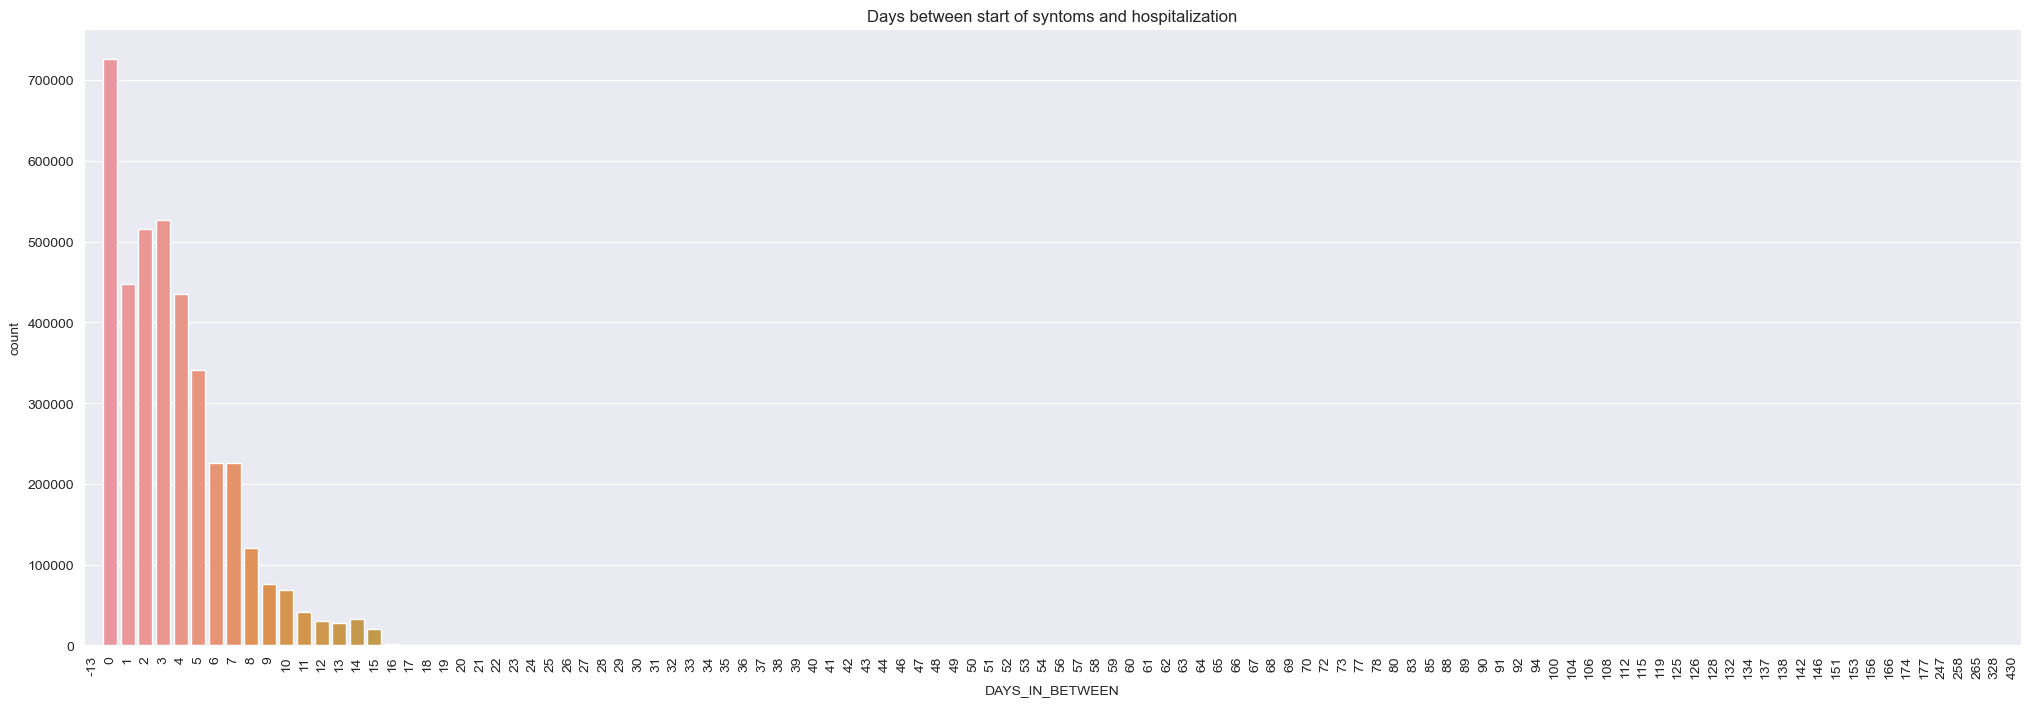

In [32]:
plt.figure(figsize=(25, 8))
cplot = sns.countplot(x=df["DAYS_IN_BETWEEN"])
cplot.set_xticklabels(cplot.get_xticklabels(), rotation=90)
cplot.set_title('Days between start of syntoms and hospitalization')

In [33]:
# is there a correlation between the days and the death?
df_dead = df[['DAYS_IN_BETWEEN', 'FECHA_DEF']].copy()
df_dead['DEAD'] = np.where(df_dead[['FECHA_DEF']].isna(), False, True)
df_dead[['DAYS_IN_BETWEEN', 'DEAD']].corr()

,DAYS_IN_BETWEEN,DEAD
DAYS_IN_BETWEEN,1.000000,0.093543
DEAD,0.093543,1.000000


We can say that no, there is not a visible correlation. Since the correlation between the two features is close to 0. 

[Text(0, 0, 'Likely to survive'), Text(1, 0, 'Likely to die')]

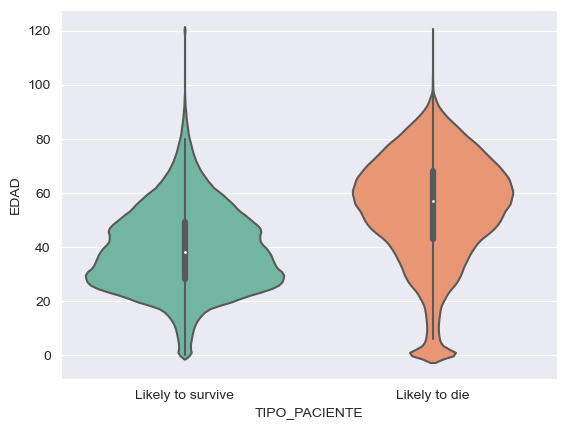

In [34]:
# explore the age of people and their classification
violin_plot = sns.violinplot(x=df["TIPO_PACIENTE"], y = df['EDAD'])
violin_plot.set_xticklabels(['Likely to survive', 'Likely to die'])

From the violion plot above, we can conclude that most of the people that were hospitalized (likely to die) had 60 years. The distrubution of people that were considered likely to die grows with the age until 60. 

Most of the people that were likely to survive has around 20-40 years instead.

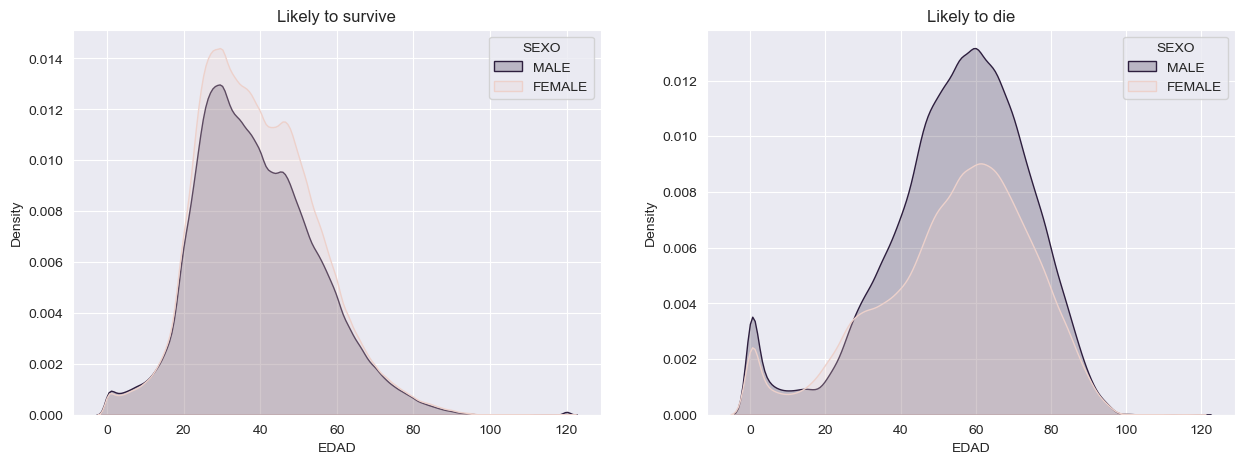

In [35]:
# is the distribution of people that were likely to die/survive different between man and women?

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

c1 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==1], x='EDAD', hue = 'SEXO', fill=True, ax=ax1)
c1.set_title("Likely to survive")
c2 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==2], x='EDAD', hue = 'SEXO', fill=True, ax=ax2)
c2.set_title("Likely to die")

c1.legend(title='SEXO', labels=['MALE', 'FEMALE'])
c2.legend(title='SEXO', labels=['MALE', 'FEMALE'])

plt.show()

From the density plot we can see that the percentage of mens in their 60 that were likely to die is higher than womens. However the difference in sex between the ones that were likely to survive is minimal.

<AxesSubplot:>

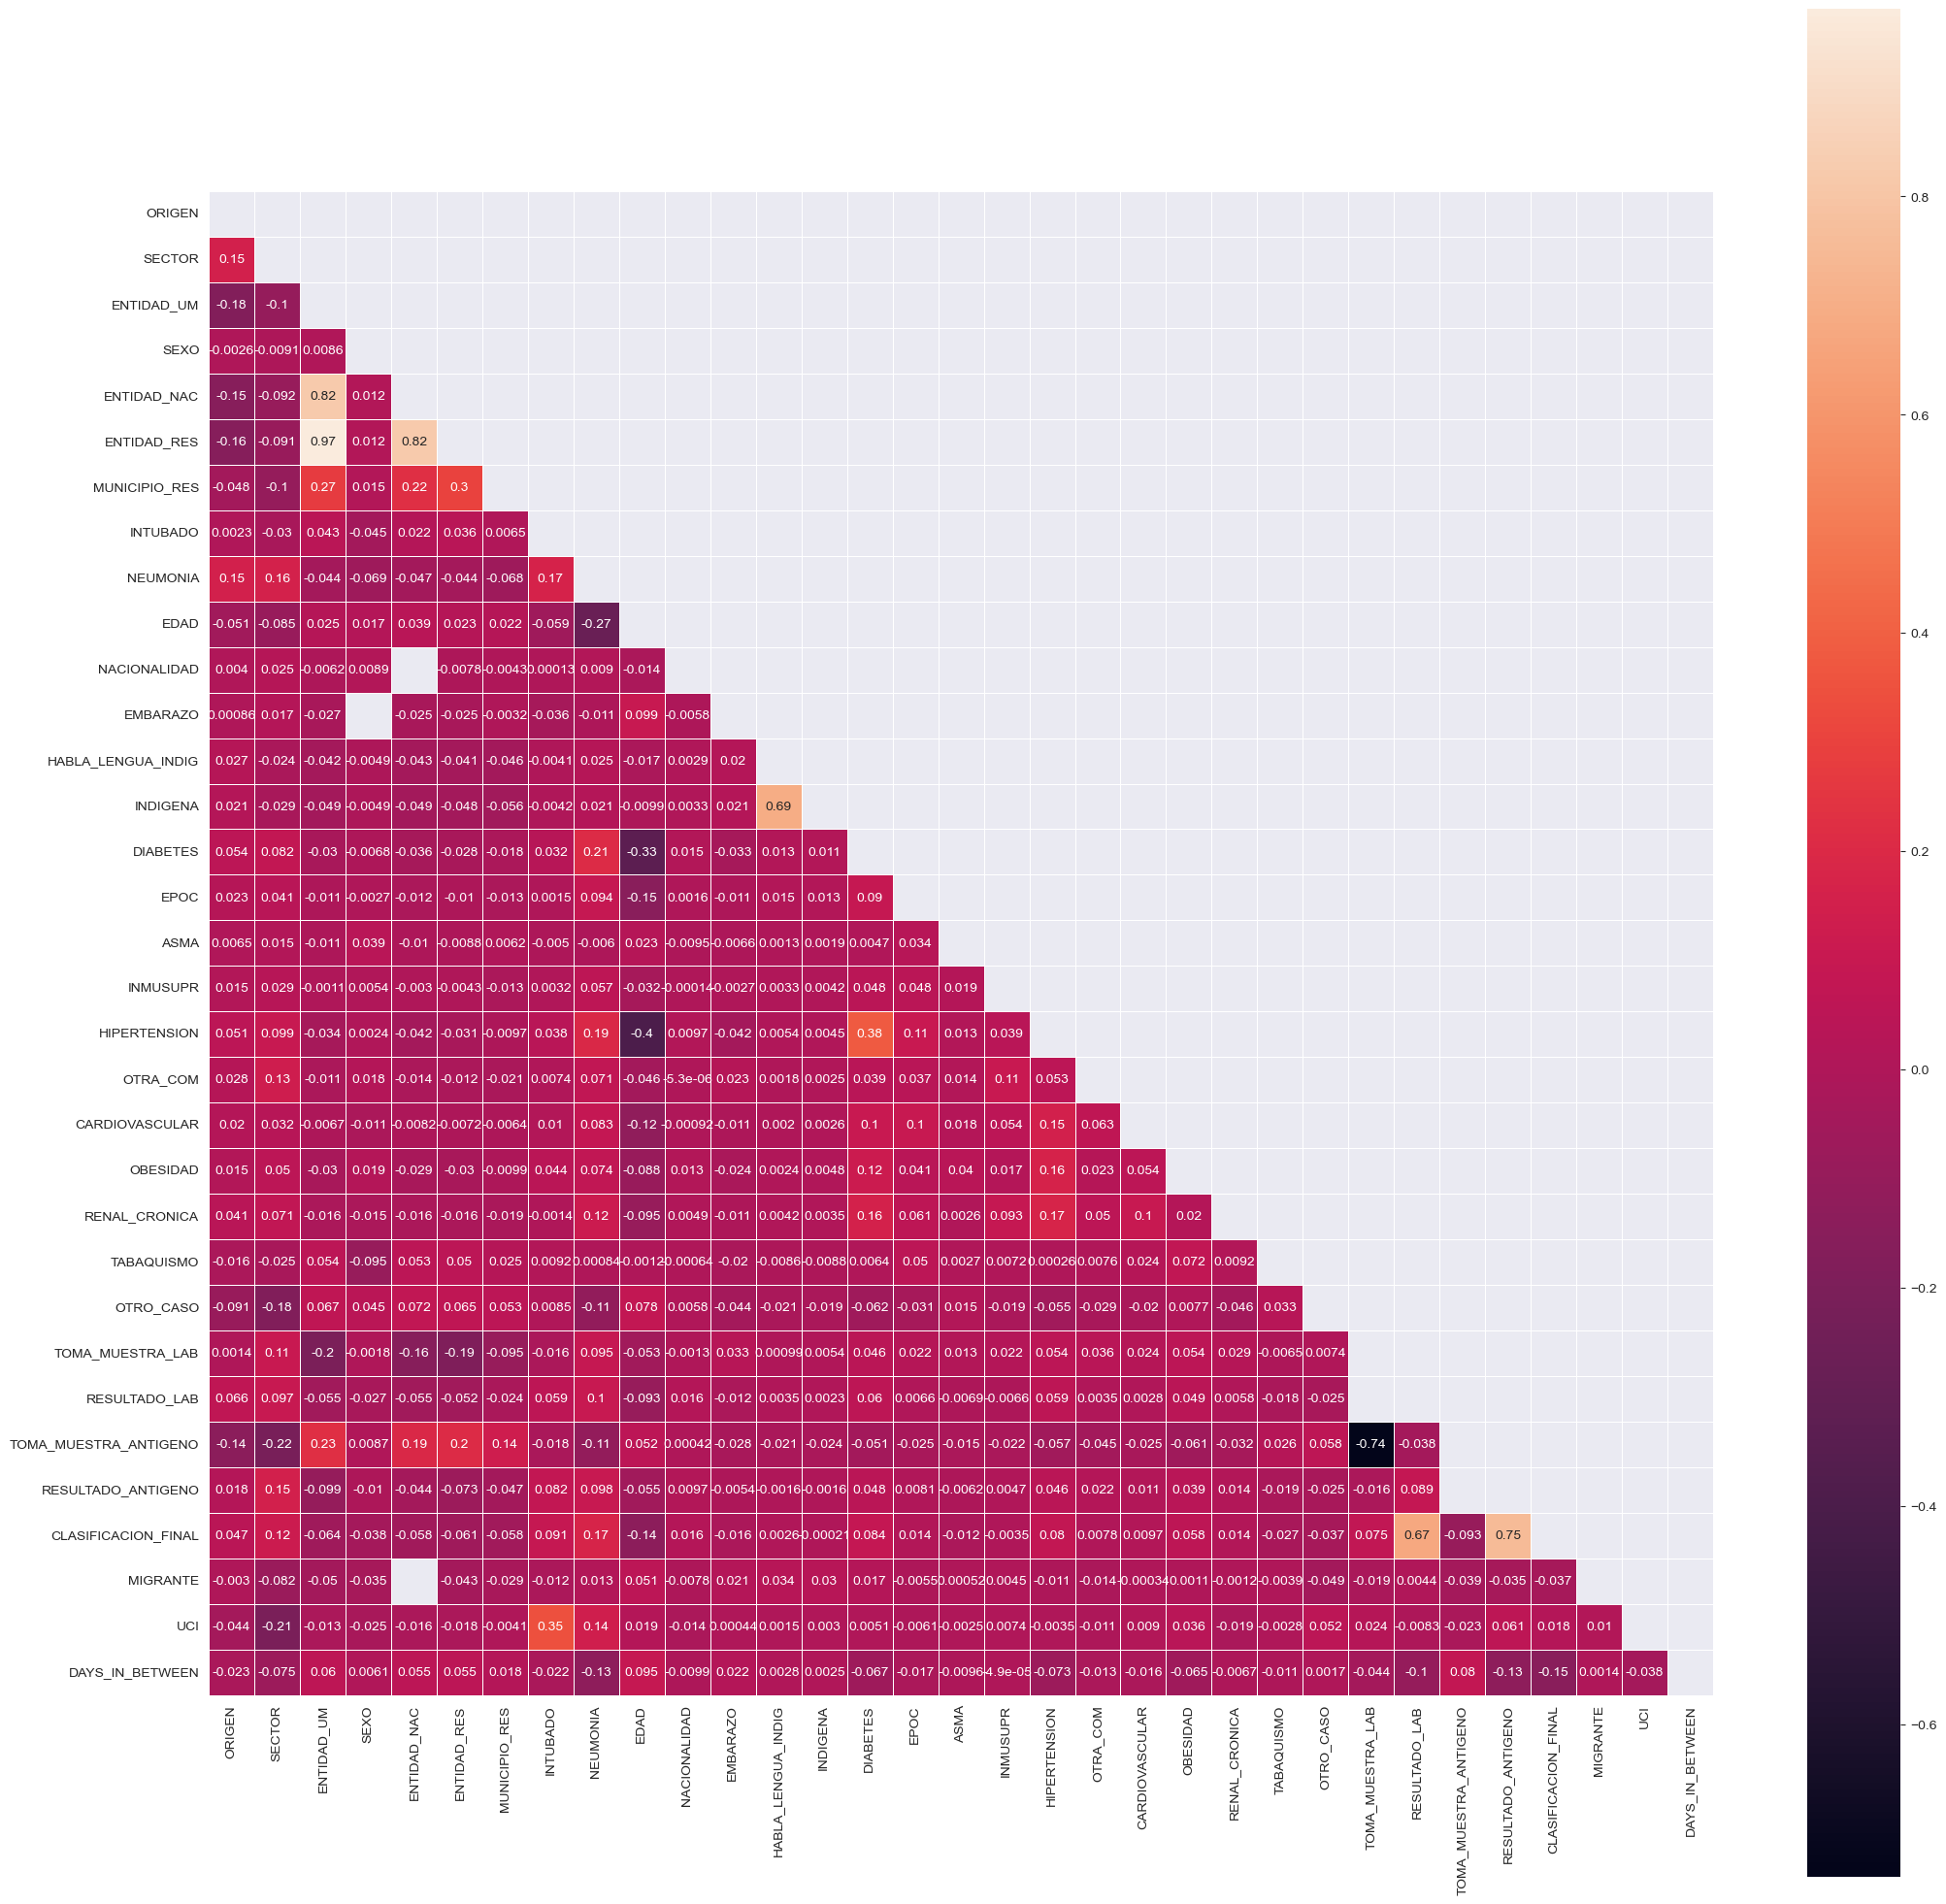

In [41]:
# correlation plot
df_corr = df.copy()
df_corr.pop('TIPO_PACIENTE')

plt.figure(figsize=(25, 25))
corr_matrix=df_corr.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidth=.5, annot=True)

The correlation plot show us wich features are highly correlated between themselves and which not. This can be useful because if we notice that two features are highly correlated (the more the correlation close to 1/-1, the more correlated) we can delete one and leave the other without removing information but improving training time.

For example 'ENTIAD_RES' and 'ENTIAD_UM' have an high correlation (0.97) so we can remove 'ENTIAD_RES' and keep 'ENTIAD_UM'.

# 3. Data Processing

**3.1 - Remove nans:** <br>
(Remove columns that have high nans and impute the ones who have less nan #(deborah))

**3.2 - Remove outliers:** (vaiva)

**3.3 - Remove redundant columns and columns that are not correlated with target variable (TIPO_PACIENTE):** (columns that have an high correlation between temselves) (vaiva)

**3.4 - Data augmentation of minority class:** (deborah)

**3.5 - Data reduction of features:** (deborah)

**3.6 - Convert Categorical Data to Numeric:** (deborah)

**3.7 - Normalization:** (deborah)